# 一、数据预处理和可视化(8分)

In [1]:
import xml.etree.ElementTree as ET
import os
import re
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

**1) 新闻数据读入与建立数据框对象(data.frame)。每篇新闻都有多个属性，不必全部保留，但是要求数据框对象中的属性至少包括全文、类别、时间，缺失的用 NA 填充。(hint: library(xml))**

In [2]:
class Data(object):
    
    def __init__(self, full_text, news_type, create_time):
        self.full_text = full_text
        self.news_type = news_type
        self.create_time = create_time

In [3]:
def get_data(path):
    full_text = ''
    news_type = []
    create_time = None
    tree = ET.parse(path)
    root = tree.getroot()
    for block in root.iter('block'):
        if block.attrib['class'] == 'full_text':
            full_text = ''
            for p in block:
                full_text += p.text
    for classifier in root.iter('classifier'):
        s = classifier.text
        if s.find('Top/News/') == 0 or s.find('Top/Features/') == 0:
            t = s.find('/')
            s = s[t+1:]
            t = s.find('/')
            s = s[t+1:]
            t = s.find('/')
            if t != -1:
                s = s[:t]
            if s not in news_type:
                news_type.append(s)
    go = {'publication_year': 0, 'publication_month': 1, 'publication_day_of_month': 2}
    for meta in root.iter('meta'):
        if meta.attrib['name'] in go:
            if create_time == None:
                create_time = ['', '', '']
            create_time[go[meta.attrib['name']]] = meta.attrib['content']
    return Data(full_text, news_type, create_time)


news_path = '../nyt_corpus/samples_500'
data = []
for cur_path, dirs, files in os.walk(news_path):
    files.sort()
    print('There\'re %d news in directory \'%s\'.' % (len(files), news_path))
    for file in files:
        path = os.path.join(cur_path, file)
        data.append(get_data(path))
print('All news loaded to \'data\'.')
print('len(data): %d' % len(data))

There're 500 news in directory '../nyt_corpus/samples_500'.
All news loaded to 'data'.
len(data): 500


**2) 对新闻全文进行预处理，包括去除标点符号、停用词、数字、空白字符，将大写字母都转化为小写，以及词干化处理。(hint: library(tm))**

In [4]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')


def preprocess(text):
    s = text.lower()
    words = re.findall(r'[a-z]+', s)
    words = [stemmer.stem(word) for word in words]
    words = [word for word in words if word not in stop_words]
    return words


for news in data:
    news.full_text = preprocess(news.full_text)
print('Full text preprocess done.')

Full text preprocess done.


**3) 将每一篇新闻的全文表示成 BagOfWords 向量。**

In [5]:
def get_bag_of_words(text):
    BOW = {}
    for word in text:
        if word in BOW:
            BOW[word] += 1
        else:
            BOW[word] = 1
    return BOW


for news in data:
    news.BOW = get_bag_of_words(news.full_text)
print('Got all BagOfWords vector.')

Got all BagOfWords vector.


**4) 考虑单词在所有新闻中的出现次数。给出出现次数最多的 100 个词并对这些词画出“云图”。(hint: library(wordcloud))**

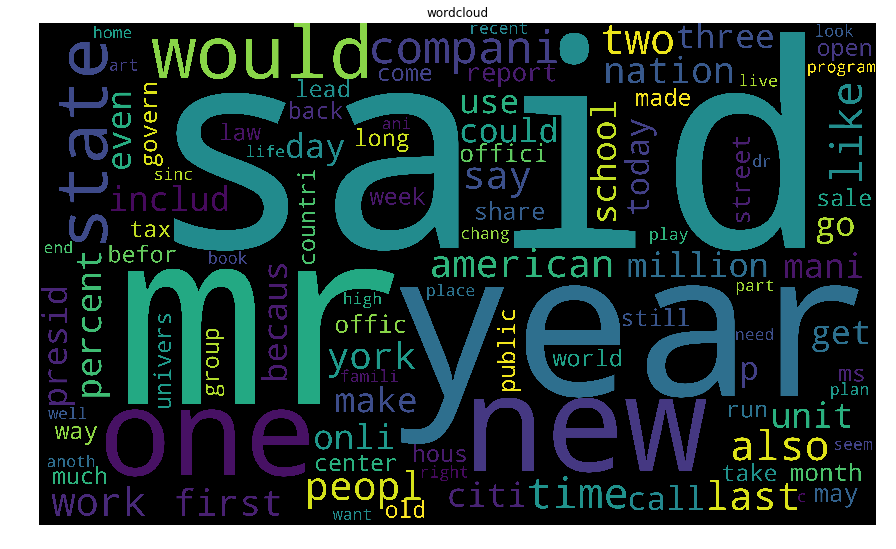

In [19]:
dictionary = {}
for news in data:
    for word, num in news.BOW.items():
        if word in dictionary:
            dictionary[word] += num
        else:
            dictionary[word] = num
a = [(key, value) for key, value in dictionary.items()]
a.sort(key=lambda x:x[1], reverse=True)
a = a[:100]
b = {}
for key, value in a:
    b[key] = value
wc = WordCloud(scale=4, background_color='black', width=2000, height=1200).generate_from_frequencies(b)
plt.figure(figsize=(15,10))
plt.title('wordcloud')
plt.imshow(wc)
plt.axis('off')
plt.show()

**5) 给出单词长度的分布情况并画出直方图。(hint: library(ggplot2))**

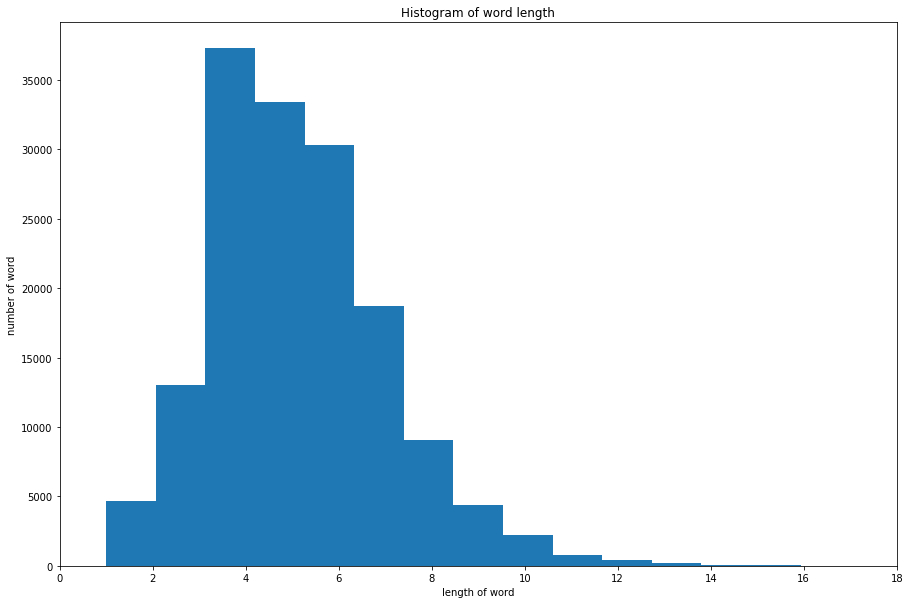

In [18]:
a = []
for word, num in dictionary.items():
    for i in range(num):
        a.append(len(word))
plt.figure(figsize=(15,10))
plt.title('Histogram of word length')
plt.hist(a, 30)
plt.xlim((0,18))
plt.xlabel('length of word')
plt.ylabel('number of word')
plt.show()

**6) 考虑新闻全文的单词数，分别使用等深分箱和等宽分箱将所有新闻分成 10  个箱，并画出每个箱包含的新闻数量的直方图。**

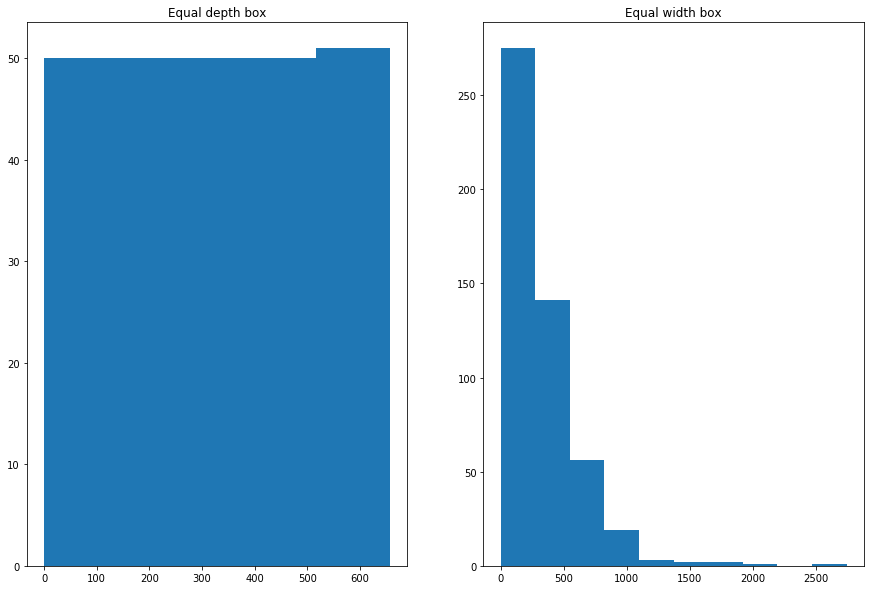

In [47]:
a = []
for news in data:
    a.append(len(news.full_text))
a.sort()
b = []
for i in range(0, 500, 50):
    b.append(a[i])
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title('Equal depth box')
plt.hist(a, bins=b)
plt.subplot(1, 2, 2)
plt.title('Equal width box')
plt.hist(a, 10)
plt.show()

**7) 给出每一个类别下的新闻数量的分布情况并画出直方图。**

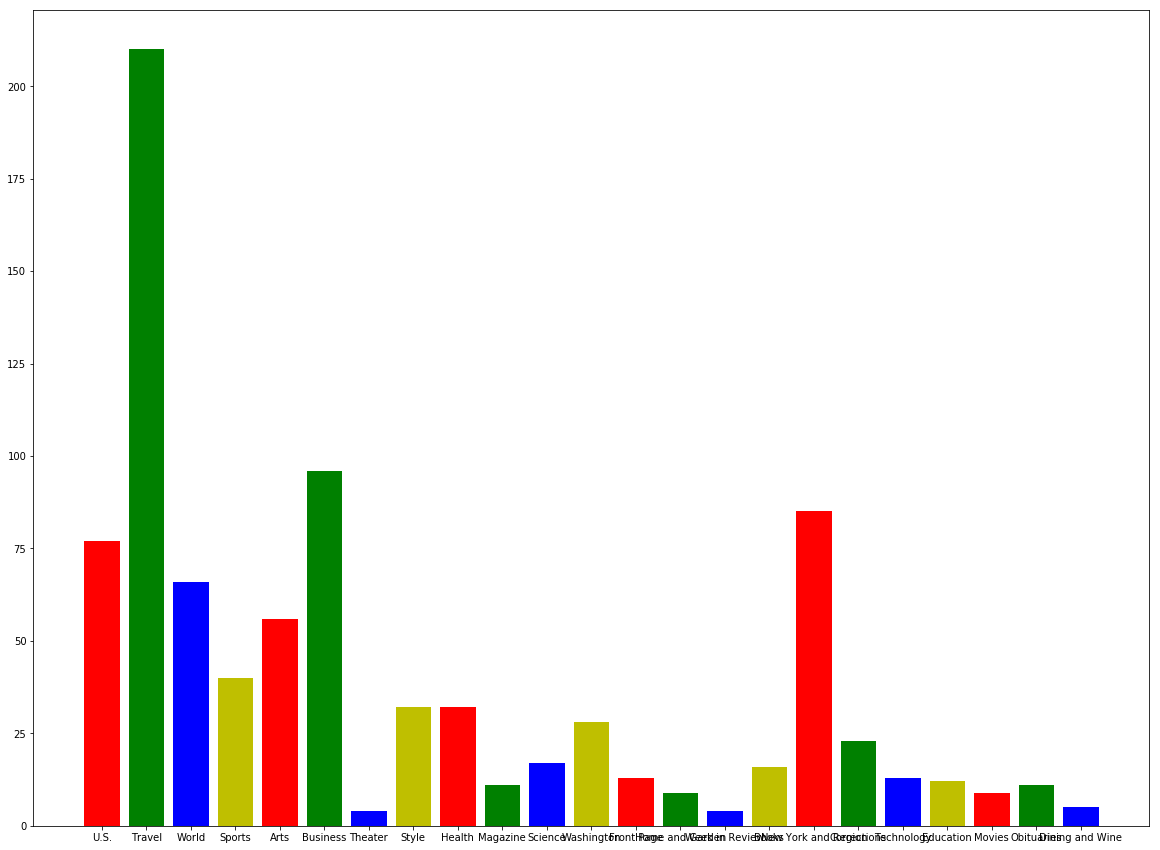

In [58]:
a = {}
for news in data:
    for t in news.news_type:
        if t in a:
            a[t] += 1
        else:
            a[t] = 1
name_list = [key for key in a]
num_list = [a[key] for key in a]
plt.figure(figsize=(20, 15))
plt.bar(range(len(num_list)), num_list, color='rgby')
index = range(len(a))
plt.xticks(index, name_list)
plt.show()

**8) 给出每个月的新闻数量的分布情况并画出直方图。**

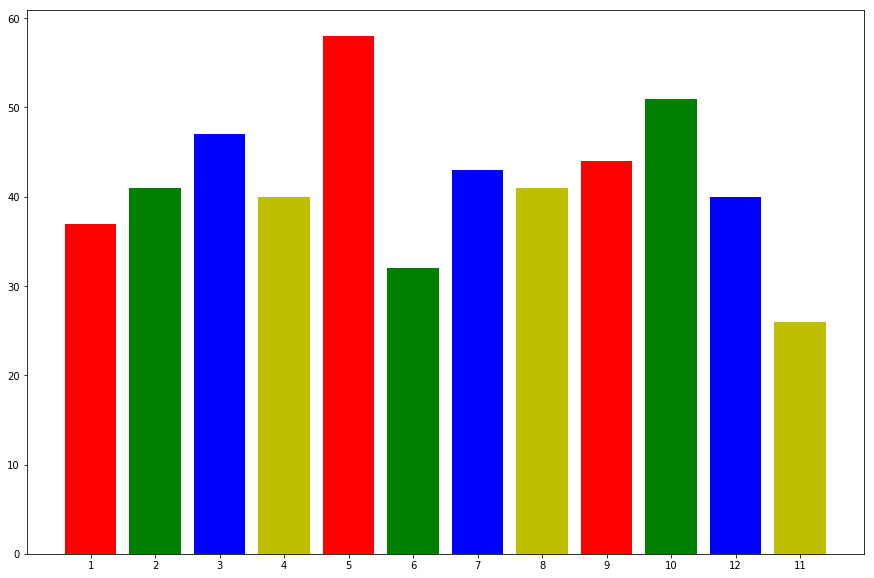

In [60]:
a = {}
for x in range(12):
    a[str(x+)]
for news in data:
    if news.create_time == None:
        continue
    t = news.create_time[1]
    if t in a:
        a[t] += 1
    else:
        a[t] = 1
name_list = [key for key in a]
num_list = [a[key] for key in a]
plt.figure(figsize=(15, 10))
plt.bar(range(len(num_list)), num_list, color='rgby')
index = range(len(a))
plt.xticks(index, name_list)
plt.show()